<a href="https://colab.research.google.com/github/isabellacadisco/Human_Value_Detection_P2/blob/main/P2_Bert_Premise.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%pip install -U transformers datasets evaluate accelerate
#%pip install optuna

Note: you may need to restart the kernel using dbutils.library.restartPython() to use updated packages.
  Using cached transformers-4.41.2-py3-none-any.whl (9.1 MB)
  Using cached datasets-2.19.1-py3-none-any.whl (542 kB)
  Using cached evaluate-0.4.2-py3-none-any.whl (84 kB)
  Using cached accelerate-0.30.1-py3-none-any.whl (302 kB)
  Using cached tokenizers-0.19.1-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (3.6 MB)
  Using cached huggingface_hub-0.23.2-py3-none-any.whl (401 kB)
  Using cached pyarrow-16.1.0-cp310-cp310-manylinux_2_28_x86_64.whl (40.8 MB)
  Attempting uninstall: pyarrow
    Found existing installation: pyarrow 8.0.0
    Not uninstalling pyarrow at /databricks/python3/lib/python3.10/site-packages, outside environment /local_disk0/.ephemeral_nfs/envs/pythonEnv-87d70bb8-7305-4fc2-9365-f0e15f284666
    Can't uninstall 'pyarrow'. No files were found to uninstall.
  Attempting uninstall: huggingface-hub
    Found existing installation: huggingface-hub 0.19.4

In [ ]:
dbutils.library.restartPython()

In [ ]:
# Importing stock ml libraries
import numpy as np
import pandas as pd
from sklearn import metrics
import transformers
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, RandomSampler, SequentialSampler
from transformers import BertTokenizer, BertModel, BertConfig

# for viz
import matplotlib.pyplot as plt

# Preparing for TPU usage
# import torch_xla
# import torch_xla.core.xla_model as xm
# device = xm.xla_device()
import copy


2024-06-02 09:46:06.101794: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-02 09:46:06.101879: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-02 09:46:06.103576: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-06-02 09:46:06.803819: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [ ]:
# # Setting up the device for GPU usage

from torch import cuda
device = 'cuda' if cuda.is_available() else 'cpu'

In [ ]:
# train
arg_training = pd.read_csv("/dbfs/mnt/tesi/hs/data_ir/arguments-training.tsv", delimiter='\t')
label_training = pd.read_csv("/dbfs/mnt/tesi/hs/data_ir/labels-training.tsv", delimiter= '\t')
df_training = pd.merge(arg_training, label_training, how='left', on="Argument ID")

In [ ]:
# validation
arg_validation = pd.read_csv("/dbfs/mnt/tesi/hs/data_ir/arguments-validation.tsv", delimiter='\t')
label_validation = pd.read_csv("/dbfs/mnt/tesi/hs/data_ir/labels-validation.tsv", delimiter= '\t')
df_validation = pd.merge(arg_validation, label_validation, how='left', on="Argument ID")



In [ ]:
# test
arg_test = pd.read_csv("/dbfs/mnt/tesi/hs/data_ir/arguments-test.tsv", delimiter='\t')
label_test = pd.read_csv("/dbfs/mnt/tesi/hs/data_ir/labels-test.tsv", delimiter= '\t')
df_test = pd.merge(arg_test, label_test, how='left', on="Argument ID")

In [ ]:
selected_col = ['Argument ID', 'Conclusion', 'Stance', 'Premise','Self-direction: action', 'Achievement', 'Security: personal', 'Security: societal', 'Benevolence: caring', 'Universalism: concern']

subset_train = df_training[selected_col]
subset_val = df_validation[selected_col]
subset_test = df_test[selected_col]


In [ ]:
subset_train['list'] = subset_train[subset_train.columns[4:]].values.tolist()
train_set = subset_train[['Premise', 'list']].copy()
train_set.head()

/root/.ipykernel/3459/command-2769935960154697-737349166:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset_train['list'] = subset_train[subset_train.columns[4:]].values.tolist()


,Premise,list
0,we should ban human cloning as it will only ca...,"[0, 0, 0, 1, 0, 0]"
1,fast food should be banned because it is reall...,"[0, 0, 1, 0, 0, 0]"
2,sometimes economic sanctions are the only thin...,"[0, 0, 0, 1, 0, 0]"
3,capital punishment is sometimes the only optio...,"[0, 0, 0, 1, 0, 1]"
4,factory farming allows for the production of c...,"[0, 0, 1, 0, 1, 1]"


In [ ]:
subset_val['list'] = subset_val[subset_val.columns[4:]].values.tolist()
val_set = subset_val[['Premise', 'list']].copy()
val_set.head()

/root/.ipykernel/3459/command-2769935960154698-977711949:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset_val['list'] = subset_val[subset_val.columns[4:]].values.tolist()


,Premise,list
0,if entrapment can serve to more easily capture...,"[0, 0, 0, 1, 0, 0]"
1,the use of public defenders should be mandator...,"[0, 0, 0, 0, 0, 1]"
2,payday loans create a more impoverished societ...,"[0, 0, 1, 0, 0, 1]"
3,Surrogacy should not be banned as it is the wo...,"[1, 0, 0, 0, 0, 0]"
4,entrapment is gravely immoral and against huma...,"[0, 0, 0, 0, 0, 1]"


In [ ]:
subset_test['list'] = subset_test[subset_test.columns[4:]].values.tolist()
test_set = subset_test[['Premise', 'list']].copy()
test_set.head()

/root/.ipykernel/3459/command-2769935960154699-2477271213:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset_test['list'] = subset_test[subset_test.columns[4:]].values.tolist()


,Premise,list
0,affirmative action helps with employment equity.,"[0, 1, 1, 0, 0, 1]"
1,affirmative action can be considered discrimin...,"[0, 1, 0, 0, 0, 1]"
2,naturopathy is very dangerous for the most vul...,"[0, 1, 1, 0, 0, 1]"
3,women shouldn't be in combat because they aren...,"[0, 1, 0, 0, 0, 0]"
4,once eradicated illnesses are returning due to...,"[0, 1, 1, 1, 1, 0]"


In [ ]:
# variables that will be used later on in the training
MAX_LEN = 189
TRAIN_BATCH_SIZE = 32
VALID_BATCH_SIZE = 32
EPOCHS = 10
LEARNING_RATE = 2e-05
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

In [ ]:
class CustomDataset(Dataset):

    def __init__(self, dataframe, tokenizer, max_len):
        self.tokenizer = tokenizer
        self.data = dataframe
        self.Premise = dataframe.Premise
        self.targets = self.data.list
        self.max_len = max_len

    def __len__(self):
        return len(self.Premise)

    def __getitem__(self, index):
        Premise = str(self.Premise[index])
        Premise = " ".join(Premise.split())

        inputs = self.tokenizer.encode_plus(
            Premise,
            None,
            add_special_tokens=True,
            max_length=self.max_len,
            #pad_to_max_length=True, deprecated
            padding='max_length',
            return_token_type_ids=True
        )
        ids = inputs['input_ids']
        mask = inputs['attention_mask']
        token_type_ids = inputs["token_type_ids"]


        return {
            'ids': torch.tensor(ids, dtype=torch.long),
            'mask': torch.tensor(mask, dtype=torch.long),
            'token_type_ids': torch.tensor(token_type_ids, dtype=torch.long),
            'targets': torch.tensor(self.targets[index], dtype=torch.float)
        }

In [ ]:
train_set = train_set.reset_index(drop=True)
test_set = test_set.reset_index(drop=True)


In [ ]:
print("TRAIN Dataset: {}".format(train_set.shape))
print("TEST Dataset: {}".format(test_set.shape))

TRAIN Dataset: (5393, 2)
TEST Dataset: (1576, 2)


In [ ]:
training_set = CustomDataset(train_set, tokenizer, MAX_LEN)
testing_set = CustomDataset(test_set, tokenizer, MAX_LEN)


In [ ]:

train_params = {'batch_size': TRAIN_BATCH_SIZE,
                'shuffle': True,
                'num_workers': 0
                }

test_params = {'batch_size': VALID_BATCH_SIZE,
                'shuffle': True,
                'num_workers': 0
                }

training_loader = DataLoader(training_set, **train_params)
testing_loader = DataLoader(testing_set, **test_params)

In [ ]:
# Creating the customized model, by adding a drop out and a dense layer on top of distil bert to get the final output for the model.

class BERTClass(torch.nn.Module):
    def __init__(self):
        super(BERTClass, self).__init__()
        self.l1 = transformers.BertModel.from_pretrained('bert-base-uncased')
        self.l2 = torch.nn.Dropout(0.3) # aumento drop out
        self.l3 = torch.nn.Linear(768, 6)

    def forward(self, ids, mask, token_type_ids):

        outputs = self.l1(ids, attention_mask=mask, token_type_ids=token_type_ids)
        output_1 = outputs.pooler_output #!!!

        output_2 = self.l2(output_1)
        output = self.l3(output_2)
        return output

model = BERTClass()
model.to(device)

BERTClass(
  (l1): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=Tr

In [ ]:
def loss_fn(outputs, targets):
    return torch.nn.BCEWithLogitsLoss()(outputs, targets)

In [ ]:
# optimizer and LR scheduler
optimizer = torch.optim.AdamW(model.parameters(), lr=LEARNING_RATE, weight_decay=0.1)  #weight decay


In [ ]:
def train(epoch):
    model.train()

    losses = []

    t_fin_targets=[]
    t_fin_outputs=[]

    for _,data in enumerate(training_loader, 0):
        ids = data['ids'].to(device, dtype = torch.long)
        mask = data['mask'].to(device, dtype = torch.long)
        token_type_ids = data['token_type_ids'].to(device, dtype = torch.long)
        targets = data['targets'].to(device, dtype = torch.float)

        # forward
        outputs = model(ids, mask, token_type_ids)

        t_fin_targets.extend(targets.cpu().detach().numpy().tolist())
        # apply SIGMOID to get multilabel predictions
        t_fin_outputs.extend(torch.sigmoid(outputs).cpu().detach().numpy().tolist())

        #optimizer.zero_grad()
        loss = loss_fn(outputs, targets)
        losses.append(loss.item())

        #if _%2000==0:
         #   print(f'Epoch: {epoch}, Loss:  {loss.item()}')

        # backward
        optimizer.zero_grad()
        loss.backward()
        # clipping
        nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()

    return t_fin_outputs, t_fin_targets, np.mean(losses)

In [ ]:
def validation(epoch):
    model.eval()

    fin_targets=[]
    fin_outputs=[]

    with torch.no_grad(): #disable gradient calculation, useful for evaluation
        for _, data in enumerate(testing_loader, 0):

            ids = data['ids'].to(device, dtype = torch.long)
            mask = data['mask'].to(device, dtype = torch.long)
            token_type_ids = data['token_type_ids'].to(device, dtype = torch.long)
            targets = data['targets'].to(device, dtype = torch.float)

            outputs = model(ids, mask, token_type_ids)
            fin_targets.extend(targets.cpu().detach().numpy().tolist())
            fin_outputs.extend(torch.sigmoid(outputs).cpu().detach().numpy().tolist())
    return fin_outputs, fin_targets

In [ ]:
metrics_train_eval = {}

In [ ]:
for epoch in range(EPOCHS):

    print(f'Epoch: {epoch}')

    # training ----------------------------------------------------------------
    train_outputs, train_targets, train_loss = train(epoch)
    # put to 1 predictions with value >= 0.5
    train_outputs = np.array(train_outputs) >= 0.5

    train_accuracy = metrics.accuracy_score(train_targets, train_outputs)
    train_f1_score_micro = metrics.f1_score(train_targets, train_outputs, average='micro')
    train_f1_score_macro = metrics.f1_score(train_targets, train_outputs, average='macro')
    train_hamming_loss = metrics.hamming_loss(train_targets, train_outputs)

    metrics_train_eval[epoch] = {'Train Accuracy Score' : train_accuracy,
                        'Train F1 Score (Micro)' : train_f1_score_micro,
                        'Train F1 Score (Macro)' : train_f1_score_macro,
                        'Train Hamming Loss' : train_hamming_loss}

    print(f"Train Accuracy Score = {train_accuracy}")
    print(f"Train F1 Score (Micro) = {train_f1_score_micro}")
    print(f"Train F1 Score (Macro) = {train_f1_score_macro}")
    print(f"Train Hamming Loss = {train_hamming_loss}")
    print(f"Train Loss = {train_loss}")


    # validation --------------------------------------------------------------

    eval_outputs, eval_targets = validation(epoch)
    # put to 1 predictions with value >= 0.5
    eval_outputs = np.array(eval_outputs) >= 0.5

    eval_accuracy = metrics.accuracy_score(eval_targets, eval_outputs)
    eval_f1_score_micro = metrics.f1_score(eval_targets, eval_outputs, average='micro')
    eval_f1_score_macro = metrics.f1_score(eval_targets, eval_outputs, average='macro')
    eval_hamming_loss = metrics.hamming_loss(eval_targets, eval_outputs)

    metrics_train_eval[epoch].update({
        'Eval Accuracy Score': eval_accuracy,
        'Eval F1 Score (Micro)': eval_f1_score_micro,
        'Eval F1 Score (Macro)': eval_f1_score_macro,
        'Eval Hamming Loss' : eval_hamming_loss
    })

    print(f"Eval Accuracy Score = {eval_accuracy}")
    print(f"Eval F1 Score (Micro) = {eval_f1_score_micro}")
    print(f"Eval F1 Score (Macro) = {eval_f1_score_macro}")
    print(f"Eval Hamming Loss = {eval_hamming_loss}")

    print('-------------------------------------------------------------------')

Epoch: 0
Train Accuracy Score = 0.14203597255701836
Train F1 Score (Micro) = 0.36986395967129343
Train F1 Score (Macro) = 0.33061712056585496
Train Hamming Loss = 0.2820013597873787
Train Loss = 0.5647316262919522
Eval Accuracy Score = 0.23096446700507614
Eval F1 Score (Micro) = 0.5599492493127511
Eval F1 Score (Macro) = 0.4983656871838446
Eval Hamming Loss = 0.22007191201353637
-------------------------------------------------------------------
Epoch: 1
Train Accuracy Score = 0.275913220841832
Train F1 Score (Micro) = 0.6139007423861577
Train F1 Score (Macro) = 0.5779720546687327
Train Hamming Loss = 0.20412262809815193
Train Loss = 0.45774914421273405
Eval Accuracy Score = 0.28553299492385786
Eval F1 Score (Micro) = 0.6279484638255699
Eval F1 Score (Macro) = 0.5924059565115148
Eval Hamming Loss = 0.19849830795262266
-------------------------------------------------------------------
Epoch: 2
Train Accuracy Score = 0.3495271648433154
Train F1 Score (Micro) = 0.6958414736254535
Train F

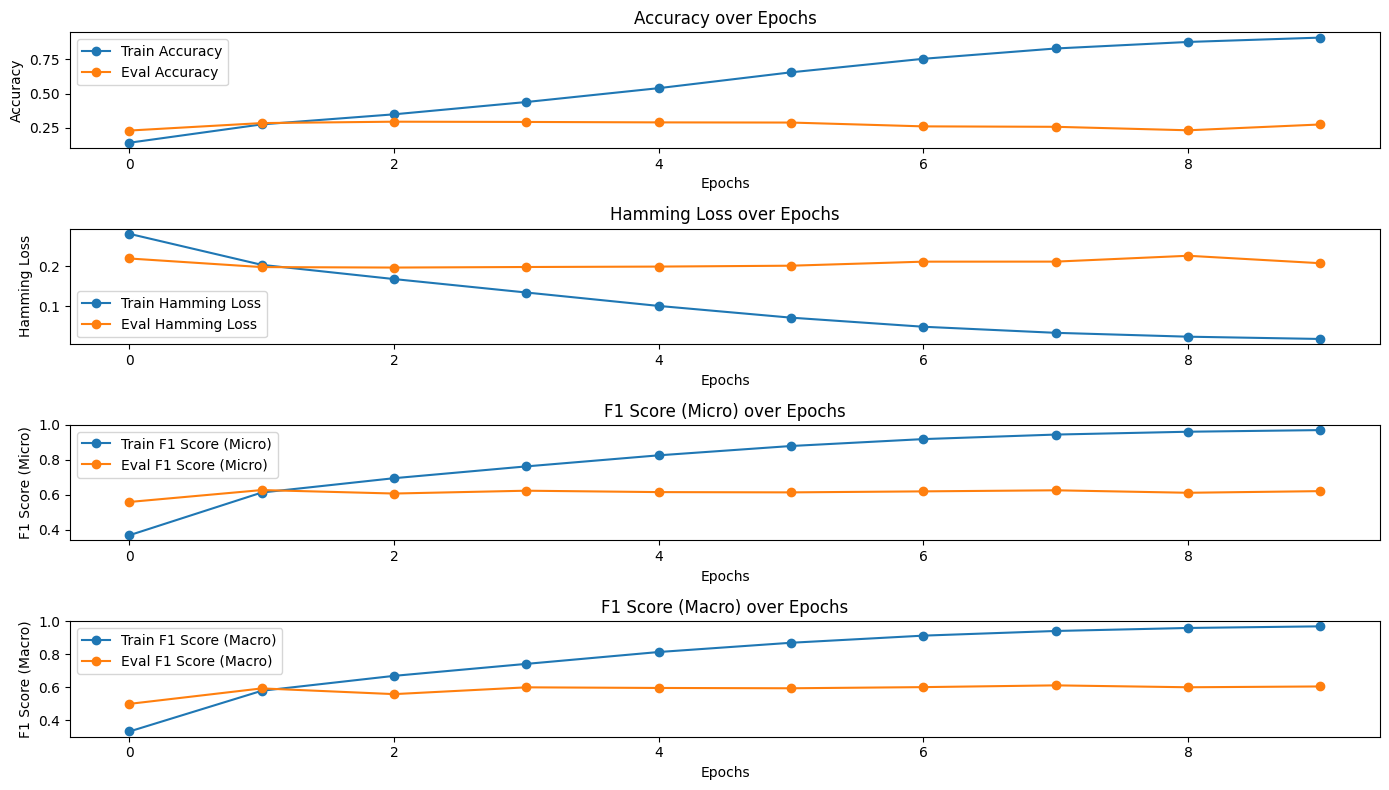

In [ ]:
# extract metrics
epochs = list(metrics_train_eval.keys())

train_accuracy = [metrics_train_eval[epoch]['Train Accuracy Score'] for epoch in epochs]
eval_accuracy = [metrics_train_eval[epoch]['Eval Accuracy Score'] for epoch in epochs]

train_f1_micro = [metrics_train_eval[epoch]['Train F1 Score (Micro)'] for epoch in epochs]
eval_f1_micro = [metrics_train_eval[epoch]['Eval F1 Score (Micro)'] for epoch in
epochs]

train_f1_macro = [metrics_train_eval[epoch]['Train F1 Score (Macro)'] for epoch in epochs]
eval_f1_macro = [metrics_train_eval[epoch]['Eval F1 Score (Macro)'] for epoch in epochs]

train_h_loss = [metrics_train_eval[epoch]['Train Hamming Loss'] for epoch in epochs]
eval_h_loss = [metrics_train_eval[epoch]['Eval Hamming Loss'] for epoch in epochs]

# plot fig
plt.figure(figsize=(14, 8))

# accuracy plot
plt.subplot(4, 1, 1)
plt.plot(epochs, train_accuracy, label='Train Accuracy', marker='o')
plt.plot(epochs, eval_accuracy, label='Eval Accuracy', marker='o')
plt.title('Accuracy over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# hamming loss plot
plt.subplot(4, 1, 2)
plt.plot(epochs, train_h_loss, label='Train Hamming Loss', marker='o')
plt.plot(epochs, eval_h_loss, label='Eval Hamming Loss', marker='o')
plt.title('Hamming Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Hamming Loss')
plt.legend()

# F1 micro plot
plt.subplot(4, 1, 3)
plt.plot(epochs, train_f1_micro, label='Train F1 Score (Micro)', marker='o')
plt.plot(epochs, eval_f1_micro, label='Eval F1 Score (Micro)', marker='o')
plt.title('F1 Score (Micro) over Epochs')
plt.xlabel('Epochs')
plt.ylabel('F1 Score (Micro)')
plt.legend()

# F1 macro plot
plt.subplot(4, 1, 4)
plt.plot(epochs, train_f1_macro, label='Train F1 Score (Macro)', marker='o')
plt.plot(epochs, eval_f1_macro, label='Eval F1 Score (Macro)', marker='o')
plt.title('F1 Score (Macro) over Epochs')
plt.xlabel('Epochs')
plt.ylabel('F1 Score (Macro)')
plt.legend()

plt.tight_layout()
plt.show()

deeper look at model's outputs for single example

labels: 'Self-direction: action', 'Achievement', 'Security: personal', 'Security: societal', 'Benevolence: caring', 'Universalism: concern'

In [ ]:
test_set.head(1)

,Premise,list
0,affirmative action helps with employment equity.,"[0, 1, 1, 0, 0, 1]"


In [ ]:
test_item_0 = testing_set.__getitem__(0)
ids = test_item_0['ids'].to(device, dtype = torch.long)
mask = test_item_0['mask'].to(device, dtype = torch.long)
token_type_ids = test_item_0['token_type_ids'].to(device, dtype = torch.long)
targets = test_item_0['targets'] #

# disable gradient calculation, add an extra dimension to the input tensors using unsqueeze(0) to create a batch of size 1.
with torch.no_grad():
    outputs = model(ids.unsqueeze(0), mask.unsqueeze(0), token_type_ids.unsqueeze(0))

print("Model Output:", outputs)

outputs = torch.sigmoid(outputs).cpu().detach().numpy().tolist()
print("Model Output after SIGMOID:", outputs)

outputs = np.array(outputs) >= 0.5

# model's output and the actual target
print("Model Output threshold:", outputs)
print("Actual Target:", targets)

Model Output: tensor([[-4.1753,  5.0593,  0.7215, -4.7745, -4.2107,  3.2038]],
       device='cuda:0')
Model Output after SIGMOID: [[0.0151384761556983, 0.9936902523040771, 0.6729267239570618, 0.008371720090508461, 0.014619379304349422, 0.9609754085540771]]
Model Output threshold: [[False  True  True False False  True]]
Actual Target: tensor([0., 1., 1., 0., 0., 1.])


In [ ]:
# flat the outputs and targets arrays
outputs_flat = np.ravel(outputs)
targets_flat = np.ravel(targets)

print("Accuracy Score:", metrics.accuracy_score(targets_flat, outputs_flat))
print("F1 micro Score:", metrics.f1_score(targets_flat, outputs_flat, average='micro'))
print("F1 macro Score:", metrics.f1_score(targets_flat, outputs_flat, average='macro'))
print("Hamming loss:", metrics.hamming_loss(targets_flat, outputs_flat))

Accuracy Score: 1.0
F1 micro Score: 1.0
F1 macro Score: 1.0
Hamming loss: 0.0


In [ ]:
test_set[87:88]

,Premise,list
87,marriage is antiquated and does not provide mu...,"[0, 0, 1, 0, 0, 1]"


In [ ]:
test_item_0 = testing_set.__getitem__(87)
ids = test_item_0['ids'].to(device, dtype = torch.long)
mask = test_item_0['mask'].to(device, dtype = torch.long)
token_type_ids = test_item_0['token_type_ids'].to(device, dtype = torch.long)
targets = test_item_0['targets'] #

# disable gradient calculation, add an extra dimension to the input tensors using unsqueeze(0) to create a batch of size 1.
with torch.no_grad():
    outputs = model(ids.unsqueeze(0), mask.unsqueeze(0), token_type_ids.unsqueeze(0))

print("Model Output:", outputs)

outputs = torch.sigmoid(outputs).cpu().detach().numpy().tolist()
print("Model Output after SIGMOID:", outputs)

outputs = np.array(outputs) >= 0.5

# model's output and the actual target
print("Model Output threshold:", outputs)
print("Actual Target:", targets)

Model Output: tensor([[-6.5262,  2.8609, -0.3593,  0.6944, -6.2437, -1.8587]],
       device='cuda:0')
Model Output after SIGMOID: [[0.0014624615432694554, 0.9458810687065125, 0.4111190438270569, 0.6669526696205139, 0.0019388027722015977, 0.13485053181648254]]
Model Output threshold: [[False  True False  True False False]]
Actual Target: tensor([0., 0., 1., 0., 0., 1.])


In [ ]:
# flat the outputs and targets arrays
outputs_flat = np.ravel(outputs)
targets_flat = np.ravel(targets)

print("Accuracy Score:", metrics.accuracy_score(targets_flat, outputs_flat))
print("F1 micro Score:", metrics.f1_score(targets_flat, outputs_flat, average='micro'))
print("F1 macro Score:", metrics.f1_score(targets_flat, outputs_flat, average='macro'))
print("Hamming loss:", metrics.hamming_loss(targets_flat, outputs_flat))

Accuracy Score: 0.3333333333333333
F1 micro Score: 0.3333333333333333
F1 macro Score: 0.25
Hamming loss: 0.6666666666666666


In [ ]:
test_set[1456:1457]

,Premise,list
1456,Immigrants from non-European countries are als...,"[0, 0, 0, 0, 0, 0]"


In [ ]:
test_item_0 = testing_set.__getitem__(1456)
ids = test_item_0['ids'].to(device, dtype = torch.long)
mask = test_item_0['mask'].to(device, dtype = torch.long)
token_type_ids = test_item_0['token_type_ids'].to(device, dtype = torch.long)
targets = test_item_0['targets'] #

# disable gradient calculation, add an extra dimension to the input tensors using unsqueeze(0) to create a batch of size 1.
with torch.no_grad():
    outputs = model(ids.unsqueeze(0), mask.unsqueeze(0), token_type_ids.unsqueeze(0))

print("Model Output:", outputs)

outputs = torch.sigmoid(outputs).cpu().detach().numpy().tolist()
print("Model Output after SIGMOID:", outputs)

outputs = np.array(outputs) >= 0.5

# model's output and the actual target
print("Model Output threshold:", outputs)
print("Actual Target:", targets)

Model Output: tensor([[-6.0261, -1.0200,  3.4475,  1.5776, -5.1964, -4.7545]],
       device='cuda:0')
Model Output after SIGMOID: [[0.002409121720120311, 0.26503318548202515, 0.9691562056541443, 0.8288607001304626, 0.005505826324224472, 0.008539472706615925]]
Model Output threshold: [[False False  True  True False False]]
Actual Target: tensor([0., 0., 0., 0., 0., 0.])


In [ ]:
# flat the outputs and targets arrays
outputs_flat = np.ravel(outputs)
targets_flat = np.ravel(targets)

print("Accuracy Score:", metrics.accuracy_score(targets_flat, outputs_flat))
print("F1 micro Score:", metrics.f1_score(targets_flat, outputs_flat, average='micro'))
print("F1 macro Score:", metrics.f1_score(targets_flat, outputs_flat, average='macro'))
print("Hamming loss:", metrics.hamming_loss(targets_flat, outputs_flat))

Accuracy Score: 0.6666666666666666
F1 micro Score: 0.6666666666666666
F1 macro Score: 0.4
Hamming loss: 0.3333333333333333


look at accuracy per single label
(for binary classification acc is equal to f1 micro)

In [ ]:
n_labels = 6
value_col = selected_col[4:]
acc = dict()

In [ ]:
e_t = np.array(eval_targets)
e_p = np.array(eval_outputs)

In [ ]:
for i in range(n_labels):
  acc[value_col[i]] = metrics.accuracy_score(e_t[:, i], e_p[:, i])

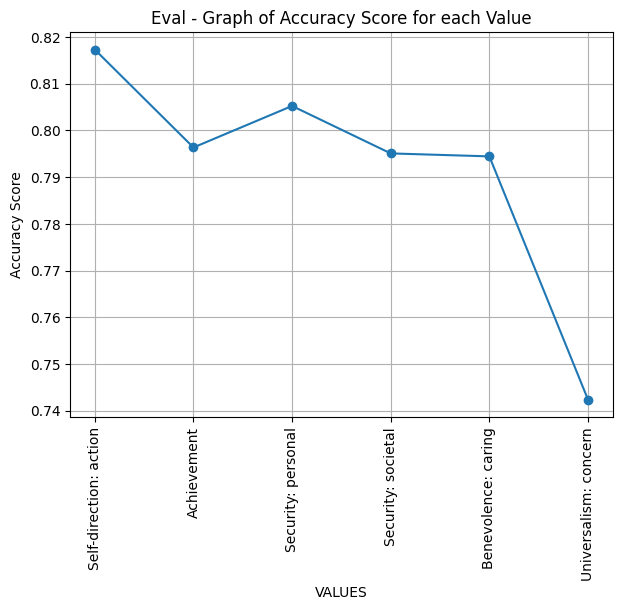

In [ ]:
plt.figure(figsize=(7, 5))

plt.plot(list(acc.keys()), list(acc.values()), marker='o')

plt.xlabel('VALUES')
plt.xticks(rotation='vertical')

plt.ylabel('Accuracy Score')
plt.title('Eval - Graph of Accuracy Score for each Value')

plt.grid(True)
plt.show()

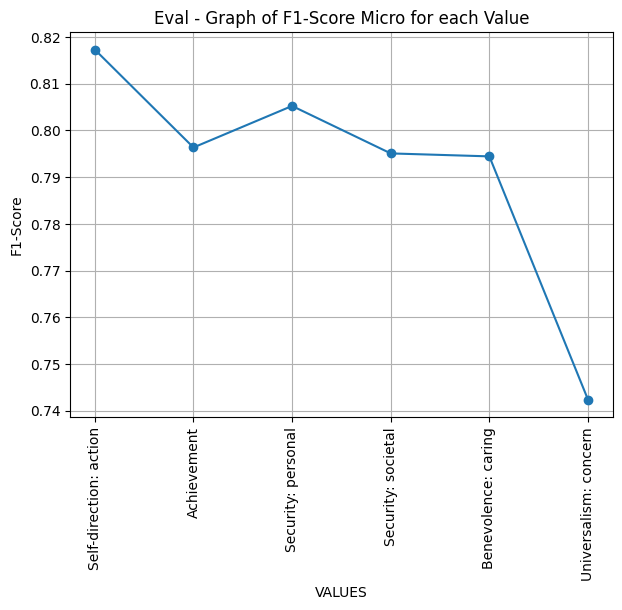

In [ ]:
f1 = dict()
for i in range(n_labels):
  f1[value_col[i]] = metrics.f1_score(e_t[:, i], e_p[:, i], average='micro')

plt.figure(figsize=(7, 5))

plt.plot(list(f1.keys()), list(f1.values()), marker='o')

plt.xlabel('VALUES')
plt.xticks(rotation='vertical')

plt.ylabel('F1-Score')
plt.title('Eval - Graph of F1-Score Micro for each Value')

plt.grid(True)
plt.show()

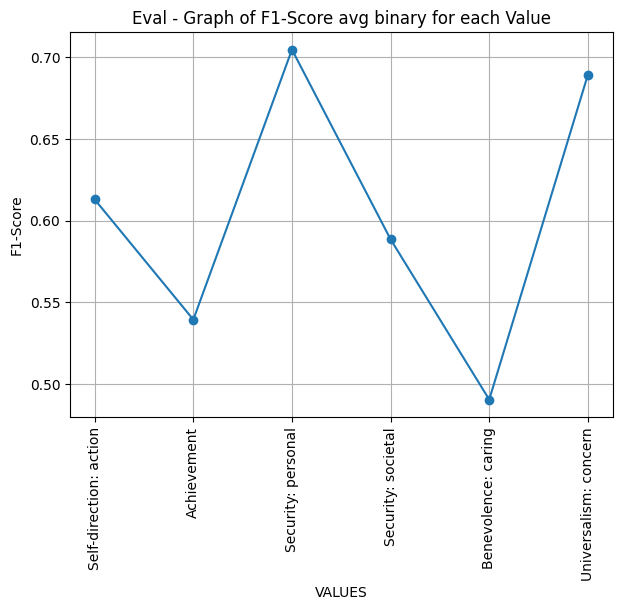

In [ ]:
f1 = dict()
for i in range(n_labels):
  f1[value_col[i]] = metrics.f1_score(e_t[:, i], e_p[:, i], average='binary')

plt.figure(figsize=(7, 5))

plt.plot(list(f1.keys()), list(f1.values()), marker='o')

plt.xlabel('VALUES')
plt.xticks(rotation='vertical')

plt.ylabel('F1-Score')
plt.title('Eval - Graph of F1-Score avg binary for each Value')

plt.grid(True)
plt.show()

comparison with train

In [ ]:
acc_t = dict()

In [ ]:
e_t_t = np.array(train_targets)
e_p_t = np.array(train_outputs)

In [ ]:
for i in range(n_labels):
  acc_t[value_col[i]] = metrics.accuracy_score(e_t_t[:, i], e_p_t[:, i])

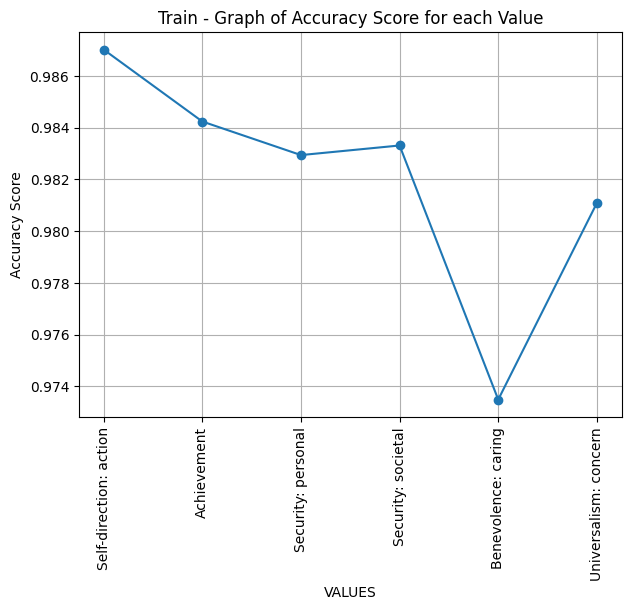

In [ ]:
plt.figure(figsize=(7, 5))

plt.plot(list(acc_t.keys()), list(acc_t.values()), marker='o')

plt.xlabel('VALUES')
plt.xticks(rotation='vertical')

plt.ylabel('Accuracy Score')
plt.title('Train - Graph of Accuracy Score for each Value')

plt.grid(True)
plt.show()